In [1]:
import numpy as np
from scipy.signal import welch

def avg_psd_across_runs(runs, fs=1.0, nperseg=None):
    """
    runs: list or array of shape (n_runs, T) - each run is a time series (0/1 or estimates)
    returns: freqs, avg_psd
    """
    runs = np.asarray(runs)
    n_runs, T = runs.shape
    if nperseg is None:
        nperseg = T
    psds = []
    for r in runs:
        f, Pxx = welch(r - r.mean(), fs=fs, nperseg=nperseg, window='hann')
        psds.append(Pxx)
    psds = np.vstack(psds)
    avg_psd = psds.mean(axis=0)   # ensemble-average PSD => removes phase effects
    return f, avg_psd

def reconstruct_from_psd(freqs, psd, T, fs=1.0, remove_dc=True):
    """
    Reconstruct a time series from PSD assuming zero phases.
    
    Parameters:
    -----------
    freqs : array
        Frequency values from PSD (from your avg_psd_across_runs)
    psd : array
        Power spectral density values
    T : int
        Desired length of reconstructed signal
    fs : float
        Sampling frequency (same as used in PSD calculation)
    remove_dc : bool
        If True, set DC component (freq=0) to zero
    
    Returns:
    --------
    t : array
        Time points
    signal : array
        Reconstructed time series
    """
    # Create frequency array for positive frequencies only
    n = T
    freqs_positive = np.fft.rfftfreq(n, d=1/fs)
    
    # Interpolate PSD to match the frequency grid
    psd_interp = np.interp(freqs_positive, freqs, psd, left=0, right=0)
    
    # Optional: remove DC component (usually removed in Welch anyway via detrending)
    if remove_dc:
        psd_interp[0] = 0
    
    # Convert PSD to amplitude spectrum
    # For Welch PSD: the relationship is amplitude = sqrt(2 * PSD * df * scaling_factor)
    # The factor of 2 accounts for the fact that PSD is one-sided (positive freqs only)
    # except for DC and Nyquist
    amplitudes = np.sqrt(2 * psd_interp)
    amplitudes[0] /= np.sqrt(2)  # DC component shouldn't be doubled
    if n % 2 == 0:  # Nyquist frequency for even n
        amplitudes[-1] /= np.sqrt(2)
    
    # Scale by sqrt of total length for proper FFT scaling
    amplitudes *= np.sqrt(n)
    
    # Create complex spectrum with zero phase
    spectrum = amplitudes * np.exp(1j * 0)
    
    # Inverse FFT (using irfft for real signals)
    signal = np.fft.irfft(spectrum, n=n)
    
    # Time array
    t = np.arange(n) / fs
    
    return t, signal

Top 5 frequencies: [0.005 0.1   0.004 0.006 0.099]


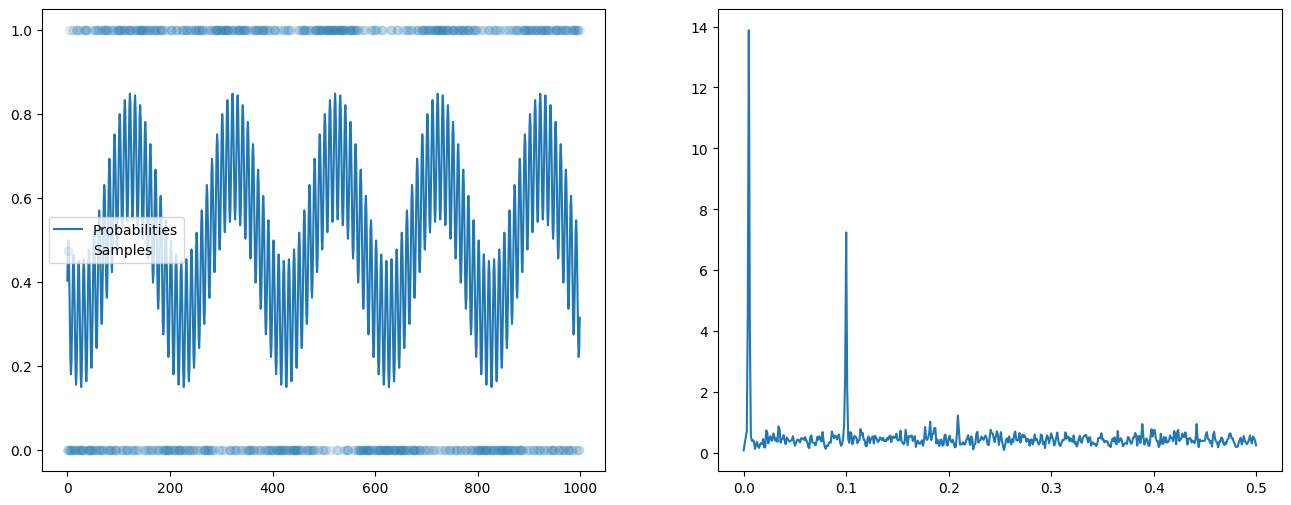

In [2]:
import matplotlib.pyplot as plt

T = 1000
np.random.seed(42)

X = np.arange(T)
n_runs = 8

probs = [(np.sin(2*np.pi/200*X - np.random.uniform(0, 2*np.pi)) * 0.8 + 
          np.sin(2*np.pi/10*X - np.random.uniform(0, 2*np.pi)) * 0.6 + 2) / 4 for _ in range(n_runs)]
probs = np.array(probs)

samples = []
for run in probs:
    samples.append([])
    for prob in run:
        samples[-1].append(np.random.choice([0,1],p=[1-prob, prob]))
samples = np.array(samples)

f, avg_psd = avg_psd_across_runs(samples)
idx = avg_psd.argsort()[::-1]
top5 = f[idx[:5]]
print("Top 5 frequencies:", top5)

fig, axs = plt.subplots(1,2, figsize=(16,6))

axs[0].plot(probs[0], label="Probabilities")
axs[0].scatter(X, samples[0], label="Samples", alpha=0.1)
axs[0].legend()

axs[1].plot(f, avg_psd)
plt.show()

Top 5 frequencies: [0.005 0.1   0.003 0.007 0.   ]


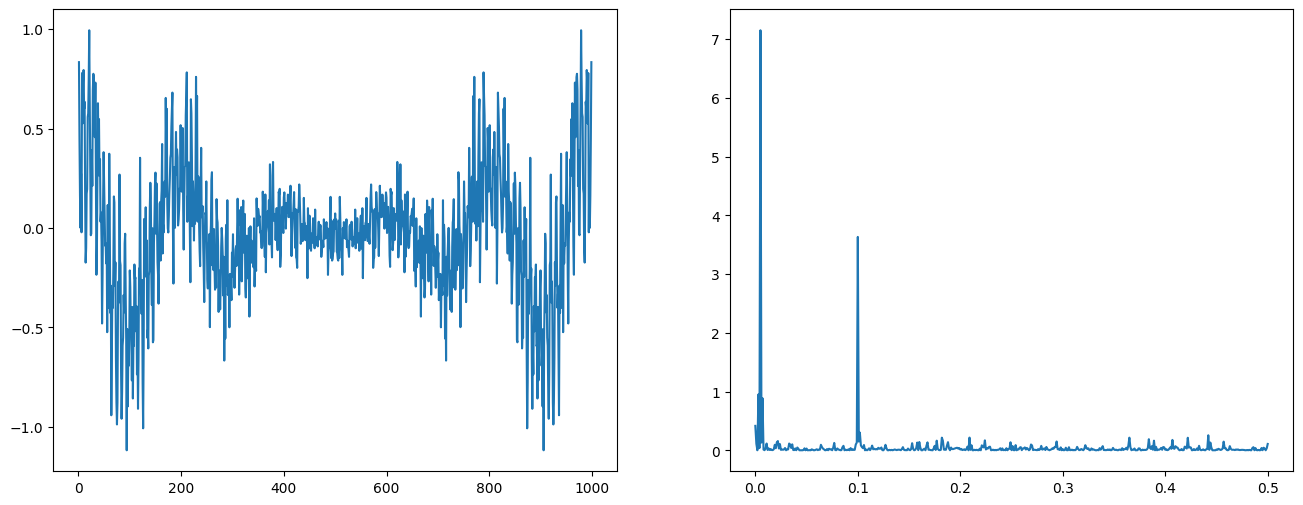

In [3]:
t, reconstruction  = reconstruct_from_psd(f, avg_psd, T)
new_f, new_avg_psd = avg_psd_across_runs(np.expand_dims(reconstruction, axis=0))
new_idx = new_avg_psd.argsort()[::-1]
top5 = new_f[new_idx[:5]]
print("Top 5 frequencies:", top5)

fig, axs = plt.subplots(1,2, figsize=(16,6))

axs[0].plot(t[1:], reconstruction[1:])
axs[1].plot(new_f, new_avg_psd)

# Analyzing planet data

In [ ]:
import pandas as pd

df = pd.read_csv("../data/multiple_runs_exploration.csv")
df = df[~((df['planet'] == 1) & (df['run'] == 8))]  # Exclude interrupted run
print(df.head())

   Unnamed: 0  trip_number  planet        planet_name  morties_sent  survived  \
0           0            1       0  "On a Cob" Planet             1     False   
1           1            2       0  "On a Cob" Planet             1     False   
2           2            3       0  "On a Cob" Planet             1     False   
3           3            4       0  "On a Cob" Planet             1     False   
4           4            5       0  "On a Cob" Planet             1      True   

   steps_taken  morties_in_citadel  morties_on_planet_jessica  morties_lost  \
0            1                 999                          0             1   
1            2                 998                          0             2   
2            3                 997                          0             3   
3            4                 996                          0             4   
4            5                 995                          1             4   

                    timestamp  run  
0

In [20]:
grouped = df[df['planet']==0].groupby('run')
on_a_cob = np.array([group['survived'].values for name, group in grouped])

grouped = df[df['planet']==1].groupby('run')
cronenberg = np.array([group['survived'].values for name, group in grouped])

grouped = df[df['planet']==2].groupby('run')
the_purge = np.array([group['survived'].values for name, group in grouped])

print(on_a_cob.shape, cronenberg.shape, the_purge.shape)

(10, 1000) (9, 1000) (10, 1000)


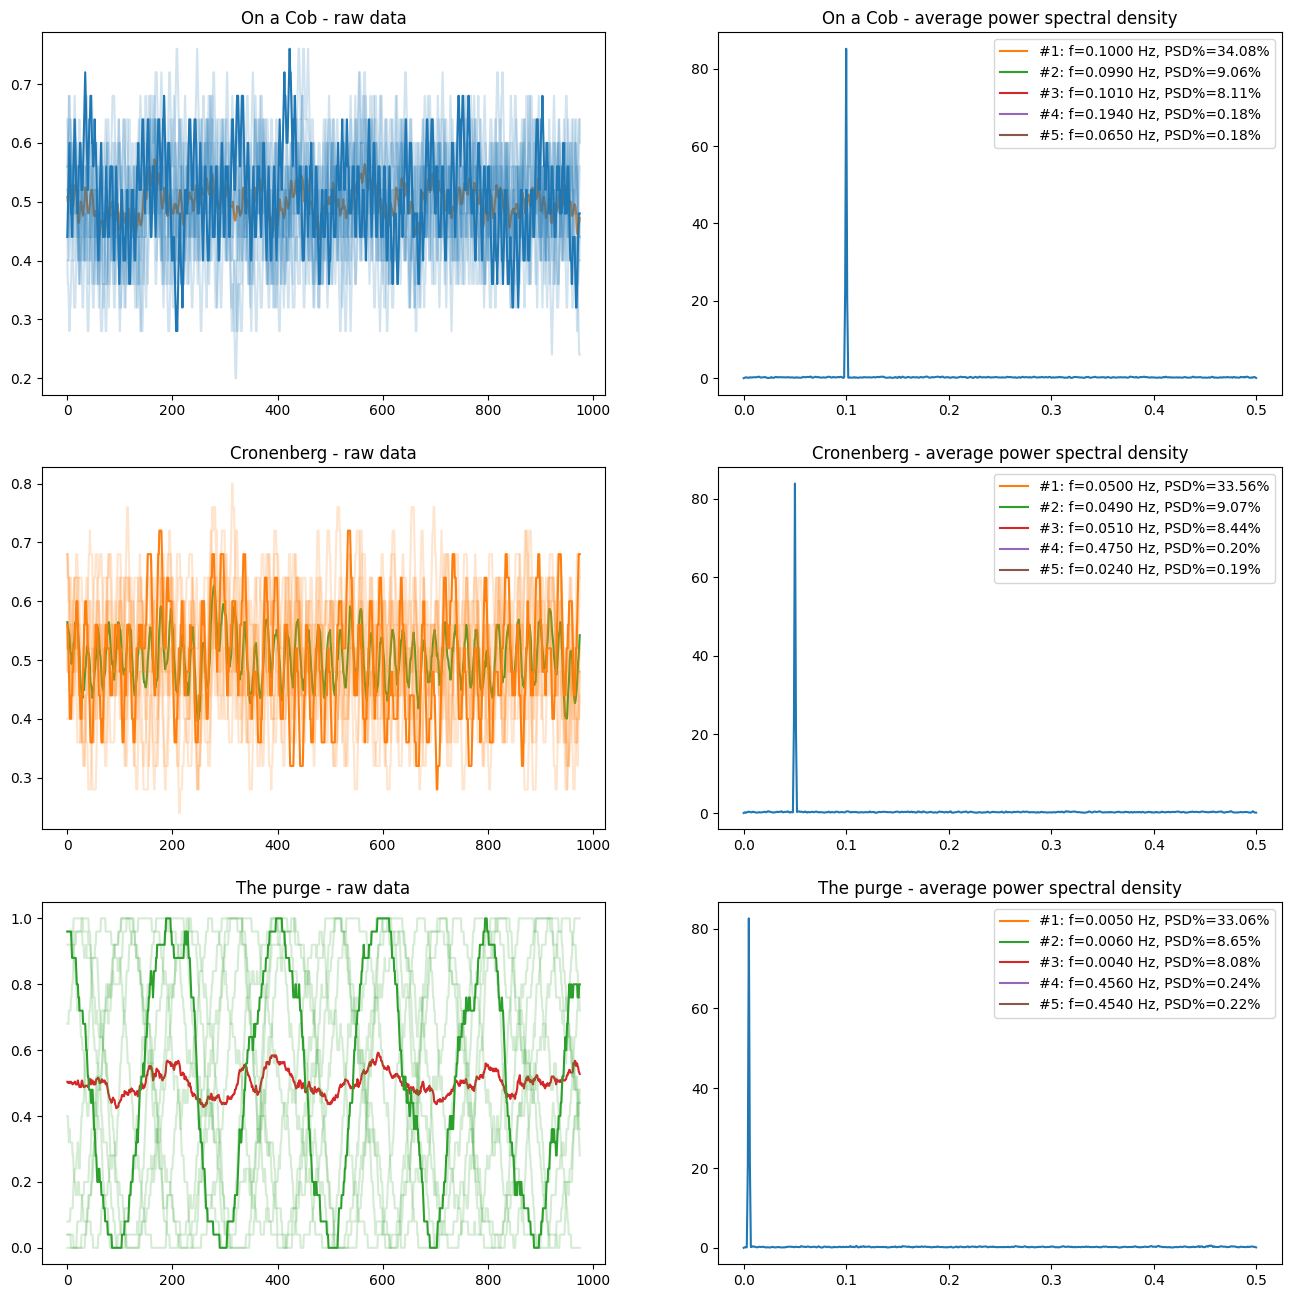

In [79]:
planet_data = {
    "On a Cob": on_a_cob,
    "Cronenberg": cronenberg,
    "The purge": the_purge
}

MA_WINDOW = 25
def moving_average(a, n=MA_WINDOW):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

fig, axs = plt.subplots(3, 2, figsize=(16, 16))

for i, (name, data) in enumerate(planet_data.items()):
    axs[i, 0].set_title(f"{name} - raw data")
    run_avg = data.mean(axis=0)
    ma_run_avg = moving_average(run_avg)
    axs[i, 0].plot(ma_run_avg, color=f"C{i+1}")
    for j, run in enumerate(data):
        ma_run = moving_average(run)
        axs[i, 0].plot(ma_run, alpha=0.2 if j > 0 else 1.0, color=f"C{i}")
    f, avg_psd = avg_psd_across_runs(data)
    axs[i, 1].set_title(f"{name} - average power spectral density")
    axs[i, 1].plot(f, avg_psd)

    idx = avg_psd.argsort()[::-1]
    total_psd = np.sum(avg_psd)
    # Create legend entries for top 3 frequencies
    for rank in range(5):
        freq = f[idx[rank]]
        psd_val = avg_psd[idx[rank]]
        psd_percent = psd_val / total_psd
        
        # Plot invisible line just for legend entry
        axs[i, 1].plot([], [], label=f"#{rank+1}: f={freq:.4f} Hz, PSD%={psd_percent*100:.2f}%")

    axs[i, 1].legend()

# Band-pass filter analysis

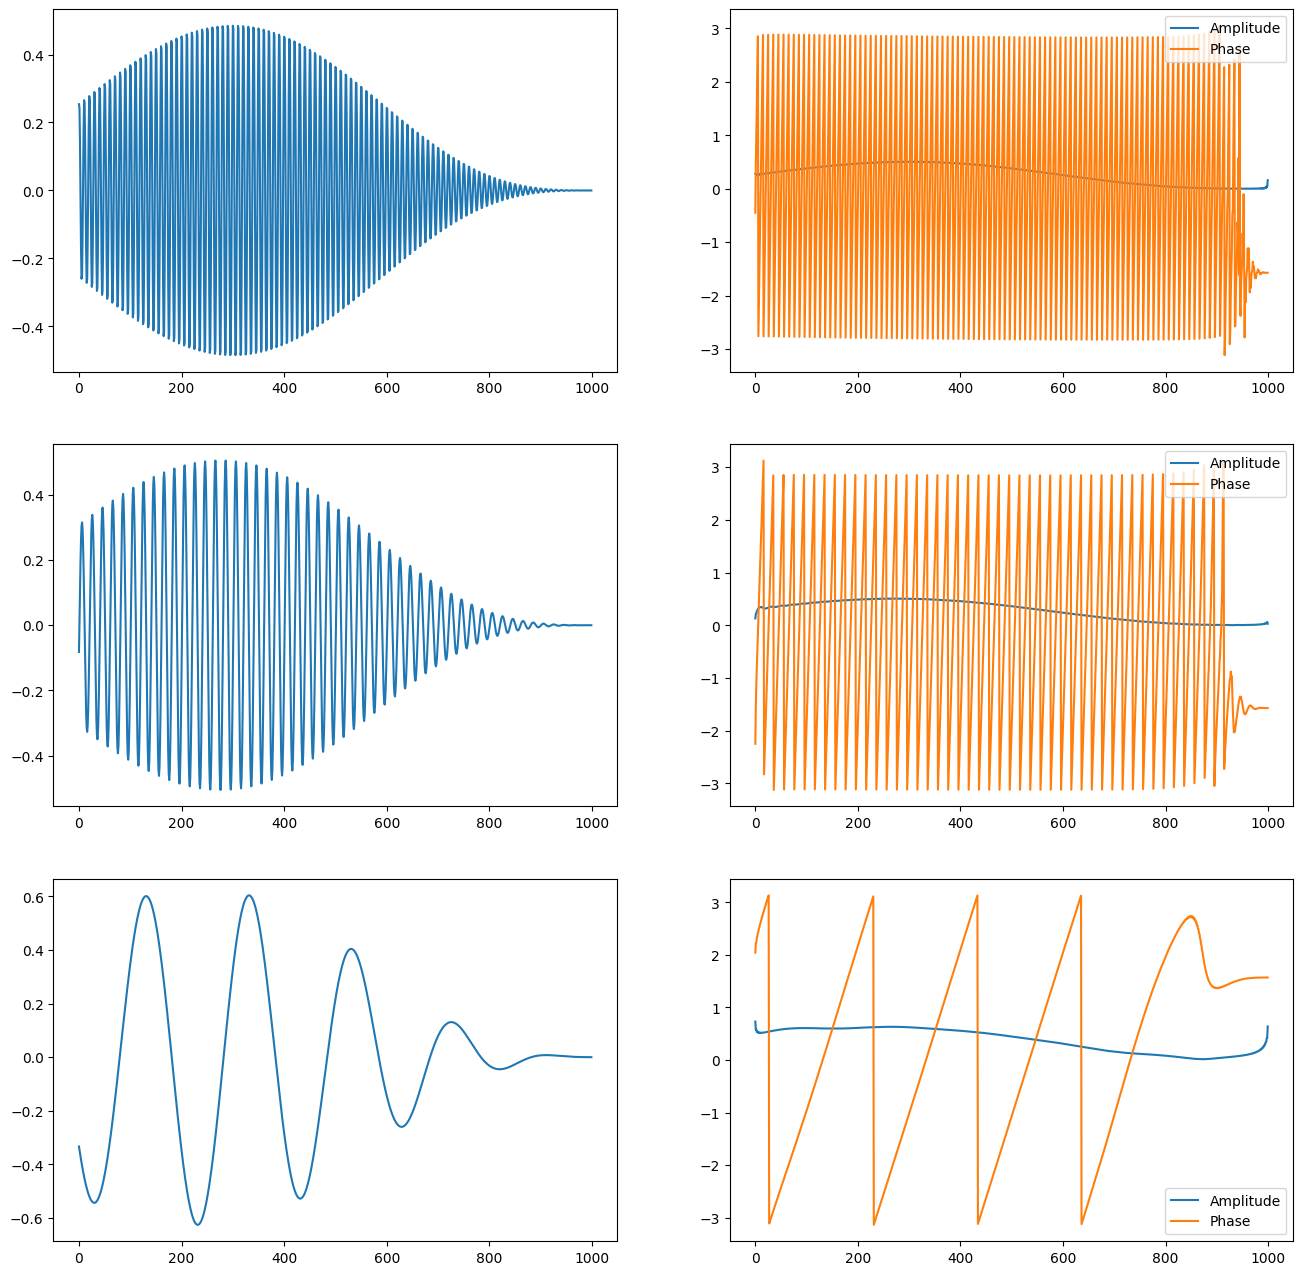

In [80]:
from scipy.signal import butter, filtfilt, hilbert

def extract_component(x, f0, bandwidth=0.01, order=4):
    # f0 = center frequency (cycles per sample)
    # bandwidth = half-width of band
    low = f0 - bandwidth/2
    high = f0 + bandwidth/2

    b, a = butter(order, [low, high], btype='band', fs=1.0)
    y = filtfilt(b, a, x)  # zero-phase
    
    analytic = hilbert(y)
    amplitude = np.abs(analytic)
    phase = np.angle(analytic)

    return y, amplitude, phase

# Try to get amplitude and phase of a single run
run = np.random.randint(9)
frequency = {
    "On a Cob": 1/10,
    "Cronenberg": 1/20,
    "The purge": 1/200
}

fig, axs = plt.subplots(3, 2, figsize=(16,16))

for i, (name, data) in enumerate(planet_data.items()):
    y, a, phi = extract_component(data[run], frequency[name], bandwidth=0.002)
    axs[i, 0].plot(y)
    axs[i, 1].plot(a, label="Amplitude")
    axs[i, 1].plot(phi, label="Phase")
    axs[i, 1].legend()